# 必要なライブラリのインポート

In [1]:
import os
import requests
import re
import glob
import datetime as dt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# 市場モデルのキャリブレーション

## データの取得・前処理

In [2]:
# 取得する csv ファイルと URL を指定する
BASE_URL = "https://cdn.cboe.com/data/us/futures/market_statistics/historical_data/VX/"
files = [
    "VX_2023-06-21.csv",
    "VX_2023-07-19.csv",
    "VX_2023-08-16.csv",
    "VX_2023-09-20.csv",
    "VX_2023-10-18.csv",
    "VX_2023-11-15.csv",
    "VX_2023-12-20.csv",
    "VX_2024-01-17.csv",
    "VX_2024-02-14.csv",
]

# csv ファイルを保存するためのディレクトリを作成する
CUR_DIR = os.getcwd()
TMP_DIR = CUR_DIR + "/VX_data/"
os.makedirs(TMP_DIR, exist_ok=True)

# csv ファイルをダウンロードする
for file in files:
  url = BASE_URL + file
  path = TMP_DIR + file
  response = requests.get(url)
  with open(path, 'wb') as f:
    for chunk in response.iter_content(100000):
      f.write(chunk)

In [3]:
# ダウンロードした csv ファイルを pandas.Dataframe としてインポートする
file_list = sorted(glob.glob(TMP_DIR + "/*.csv"))

df_list = []
for file in file_list:
  df = pd.read_csv(file)
  df_list.append(df)

df_list[0].head()

,Trade Date,Futures,Open,High,Low,Close,Settle,Change,Total Volume,EFP,Open Interest
0,2022-09-26,M (Jun 2023),29.54,29.55,29.25,29.55,29.600,0.000,2,0,2
1,2022-09-27,M (Jun 2023),29.40,29.95,29.40,29.77,29.725,0.125,36,0,34
2,2022-09-28,M (Jun 2023),29.67,29.95,29.35,29.40,29.325,-0.400,12,0,46
3,2022-09-29,M (Jun 2023),29.44,29.80,29.20,29.75,29.575,0.250,24,0,65
4,2022-09-30,M (Jun 2023),29.45,29.85,29.30,29.85,29.700,0.125,18,0,79


In [4]:
# データを整形する

# 必要なカラムを抽出する
for i in range(len(df_list)):
  df = df_list[i]  # 処理する pandas.Dataframe を取得する
  df = df[["Trade Date", "Futures", "Settle"]]  # 必要な列を抽出する
  df_list[i] = df  # pandas.Dataframe を更新する

# 2023年6月15日のデータを抽出する
columns = df_list[0].columns
df = pd.DataFrame(columns=columns)
for df_ref in df_list:
  df_add = df_ref[df_ref["Trade Date"] == "2023-06-15"]
  df = pd.concat([df, df_add])

# Trade Date 列と Futures 列のデータ型を str 型から Timestamp (datetime.datime) 型に変換する
df["Trade Date"] = pd.to_datetime(df["Trade Date"], format="%Y-%m-%d")
df["Futures"] = df["Futures"].apply(lambda str: re.search(r"\((\w{3} \d{4})\)", str).group(1))
df["Futures"] = pd.to_datetime(df["Futures"], format="%b %Y")

# Futures 列の要素に満期日を反映させる
maturity_days = [19, 16, 15, 20, 18, 15, 20, 17, 21, 19, 16, 21]

def apply_maturity_day(mat):
  for i, day in enumerate(maturity_days):
    if mat.month == i + 1:
      return mat.replace(day=day)

df["Futures"] = df["Futures"].apply(lambda mat: apply_maturity_day(mat))

# 新たに Time to Maturity 列を追加する
df["Time to Maturity"] = (df["Futures"] - df["Trade Date"]).apply(lambda t: t.days / 365)

df.head()

,Trade Date,Futures,Settle,Time to Maturity
181,2023-06-15,2023-06-15,15.1030,0.000000
161,2023-06-15,2023-07-20,17.0878,0.095890
141,2023-06-15,2023-08-17,18.2500,0.172603
117,2023-06-15,2023-09-21,19.3663,0.268493
100,2023-06-15,2023-10-19,20.0028,0.345205


## 先物の期間構造

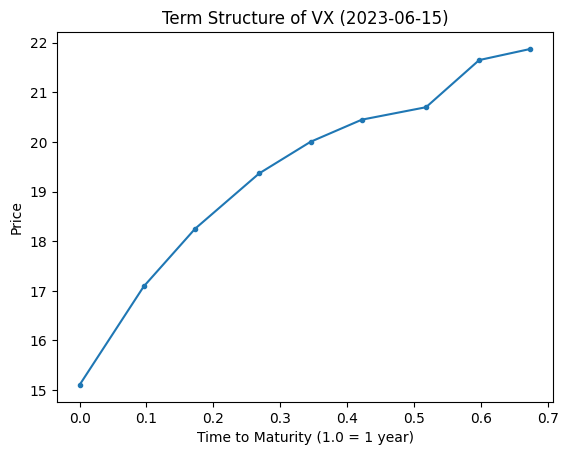

In [5]:
# 期間構造を描画する
fig = plt.figure()
ax = fig.add_subplot()

# Time to Maturity に関して重複を無くし、昇順に並び替える
df = df.drop_duplicates(subset="Time to Maturity")
df = df.sort_values(by=["Time to Maturity"])

t = df["Time to Maturity"].values
y = df["Settle"].values
plt.plot(t, y, marker=".")
plt.xlabel("Time to Maturity (1.0 = 1 year)")
plt.ylabel("Price")
plt.title("Term Structure of VX (2023-06-15)")
plt.show()

## Bergomi モデル(1次元)

In [6]:
# Bergomi model における先物価格 F(t, T) (T - t の関数として表せる)
def bergomi_model_futures_price(time_to_mat, f_inf, gamma, sigma, kappa):
  X_t = np.random.default_rng(seed=0).normal(0, np.sqrt(sigma**2 / (2 * kappa)))
  term1 = - (gamma**2 * sigma**2 * np.exp(- 2 * kappa * time_to_mat)) / (4 * kappa)
  term2 = gamma * np.exp(- kappa * time_to_mat) * X_t
  return f_inf * np.exp(term1 + term2)

# 最小化する誤差関数
def fun(params, t, y):
    f_inf = params[0]
    gamma = params[1]
    sigma = params[2]
    kappa = params[3]

    return bergomi_model_futures_price(t, f_inf, gamma, sigma, kappa) - y

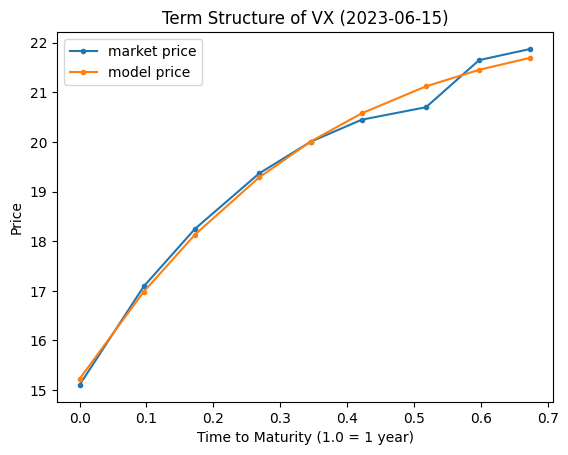

In [7]:
# 最小二乗法を用いて理論価格と市場価格からモデルをキャリブレーションする
t_train = df['Time to Maturity'].values
y_train = df['Settle'].values
initial_params = [1, 1, 1, 1]
res = least_squares(fun, initial_params, args=(t_train, y_train))

# キャリブレーションされたパラメータを取得する
params = res.x

# Bergomi モデルによる期間構造を描画する
fig = plt.figure()
ax = fig.add_subplot()

t = df["Time to Maturity"].values
y_true = df["Settle"].values
y_pred = bergomi_model_futures_price(t, params[0], params[1], params[2], params[3])
plt.plot(t, y_true, label="market price", marker=".")
plt.plot(t, y_pred, label="model price", marker=".")
plt.xlabel("Time to Maturity (1.0 = 1 year)")
plt.ylabel("Price")
plt.title("Term Structure of VX (2023-06-15)")
plt.legend()


plt.show()

In [8]:
# モデルのパラメータ
print("estimated parameters:")
print(f"- f_inf: {res.x[0]}")
print(f"- gamma: {res.x[1]}")
print(f"- sigma: {res.x[2]}")
print(f"- kappa: {res.x[3]}")

estimated parameters:
- f_inf: 22.11640068484945
- gamma: 1.1689254577957506
- sigma: 1.491185031439407
- kappa: 1.5220336551700244


# 市場モデルに適合した SVM の深層学習による構成

## 学習の準備

In [9]:
# パラメータ

# SVM
KAPPA = tf.cast(params[3], tf.float32)  # 平均回帰率
SIGMA = tf.cast(params[2], tf.float32)  # ボラティリティ
print("SVM のパラメータ")
print(f"- KAPPA: {KAPPA}")
print(f"- SIGMA: {SIGMA}\n")

# Bergomi モデル (1次元)
h0 = tf.constant(0.2, tf.float32)
GAMMA = tf.cast(params[1], tf.float32)
print("Bergomi モデルのパラメータ")
print(f"- h0: {h0}")
print(f"- GAMMA: {GAMMA}\n")

# VIX
TAU = tf.constant(30/365, tf.float32)  # 満期
print("VIX 計算式のパラメータ")
print(f"- TAU: {TAU}\n")

# OU 過程の定常分布
print("OU 過程の定常分布(正規分布): ")
print("- 平均: 0")
print("- 標準偏差: {std}".format(std=np.sqrt(SIGMA**2 / (2*KAPPA))))

SVM のパラメータ
- KAPPA: 1.52203369140625
- SIGMA: 1.4911850690841675

Bergomi モデルのパラメータ
- h0: 0.20000000298023224
- GAMMA: 1.168925404548645

VIX 計算式のパラメータ
- TAU: 0.08219178020954132

OU 過程の定常分布(正規分布): 
- 平均: 0
- 標準偏差: 0.854681670665741


In [16]:
# Bergomi モデル (1次元) における VIX
def h(x, h0):
  return h0 * tf.math.exp(GAMMA * x)

# 深層学習モデル
# ニューラルネットワークで表現されたボラティリティ関数を含む
class CustomModel(tf.keras.Model):

  def __init__(self, input_shape=(1,)):
    super(CustomModel, self).__init__()
    self.model_f = tf.keras.Sequential([
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(64, activation='tanh'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(1, activation='softplus'),  # ReLU 関数で f(x) = v^2(x) の non-negativity を保証する
    ])

  def call(self, inputs):

    # 数値微分
    delta = 1e-4
    f1 = self.model_f(inputs)
    f2 = self.model_f(inputs + delta)
    f3 = self.model_f(inputs - delta)
    f4 = self.model_f(inputs + 2 * delta)
    f5 = self.model_f(inputs - 2 * delta)
    f = f1
    df = (f2 - f3) / (2 * delta)
    ddf = (f4 - 2 * f1 + f5) / (2 * delta)**2

    # VIX_t(x)^2 を計算する
    return f + TAU * (- KAPPA * inputs * df + SIGMA**2 * ddf / 2) / 2

## 学習

In [21]:
# OU 過程の定常分布に従う確率変数のサンプル(10^5個)
# 標準偏差を 0.1 小さくすることで, 裾の部分を取り除く
x_train = tf.random.normal([100000, 1], 0., tf.math.sqrt(SIGMA**2 / (2*KAPPA)) - 0.1, dtype=tf.float32, seed=0)

# Bergomi モデル (1次元) から得られる VIX^2
VIX_squared_train = h(x_train, h0)**2

model = CustomModel()
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4), loss=tf.keras.losses.MeanSquaredError())
history = model.fit(x_train, VIX_squared_train, batch_size=256, epochs=200)

Epoch 1/200
391/391 [==============================] - 7s 5ms/step - loss: 1.0580
Epoch 2/200
391/391 [==============================] - 2s 5ms/step - loss: 0.6868
Epoch 3/200
391/391 [==============================] - 2s 5ms/step - loss: 0.5970
Epoch 4/200
391/391 [==============================] - 2s 5ms/step - loss: 0.5252
Epoch 5/200
391/391 [==============================] - 2s 6ms/step - loss: 0.5012
Epoch 6/200
391/391 [==============================] - 2s 6ms/step - loss: 0.4701
Epoch 7/200
391/391 [==============================] - 2s 5ms/step - loss: 0.4564
Epoch 8/200
391/391 [==============================] - 2s 5ms/step - loss: 0.4344
Epoch 9/200
391/391 [==============================] - 2s 5ms/step - loss: 0.4396
Epoch 10/200
391/391 [==============================] - 2s 5ms/step - loss: 0.4272
Epoch 11/200
391/391 [==============================] - 3s 7ms/step - loss: 0.4276
Epoch 12/200
391/391 [==============================] - 2s 5ms/step - loss: 0.4172
Epoch 13/200


## 結果

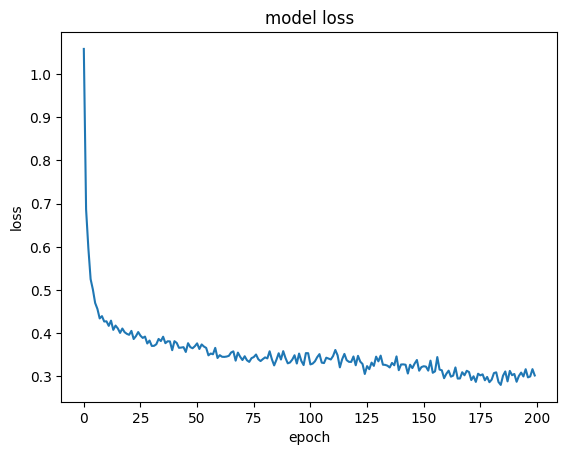

In [22]:
# 訓練誤差の推移
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('model loss')
plt.show()

32/32 [==============================] - 0s 1ms/step


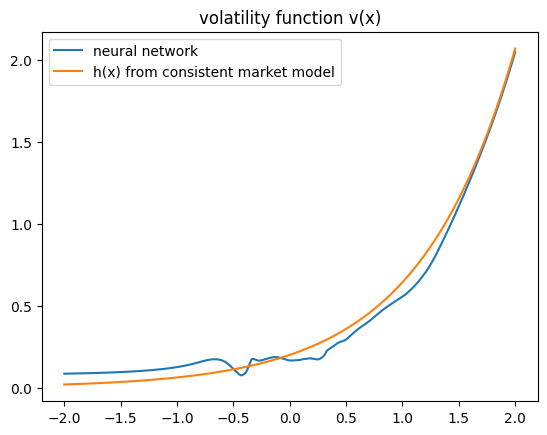

In [23]:
# 予測データ
# ボラティリティ関数
X_test = tf.linspace(-2., 2., 1000)
X_test_reshaped = tf.reshape(X_test, [X_test.shape[0], 1])
v_test = np.sqrt(model.model_f.predict(X_test_reshaped))

plt.plot(X_test, v_test)  # ニューラルネットワーク
plt.plot(X_test, h(X_test, h0))  # 一貫性のある市場モデルから得られる h(x)
plt.title('volatility function v(x)')
plt.legend(['neural network', 'h(x) from consistent market model'])
plt.show()